In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch as pt 

import sys
import os
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.mokito.modules2 import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)

Created variables:
inp_dir = input/
out_trajectories1 = output/trajectories/
out_trajectories2 = output/trajectories/openmm_files/
out_trajectories3 = output/trajectories/openmm_files/initial_states/
out_trajectories4 = output/trajectories/openmm_files/final_states/
out_trajectories5 = output/trajectories/openmm_files/final_states_nh/
out_isokann = output/isokann/
out_mokito = output/mokito/

cuda


In [ ]:
# Load initial and final states 
pdbfile_water    = 'pdbfile_water.pdb' 
file_traj_water  = 'trajectory_water.dcd'

mdtraj =  md.load(out_trajectories2 + file_traj_water, top = inp_dir + pdbfile_water).remove_solvent() 
atoms_BB = mdtraj.topology.select("backbone")
mdtraj = mdtraj.atom_slice(atoms_BB)

X0     = pt.load(out_trajectories1 + 'BAT_0.pt', map_location=device).cpu().detach().numpy()         

# Load chi function
chi0 = np.loadtxt(out_isokann + 'chi0.txt')     #  chi0.shape = (Npoints,)

data           =  OrganizeData( X0, chi0, MDtraj = mdtraj)

FIs    =  FindIntervals(data, Nintervals=5, clustering = 'grid')

Check shape of input data
X0.shape   =  (6000, 1716)
chi0.shape =  (6000,)
  


259
1597
1877
1095
1172


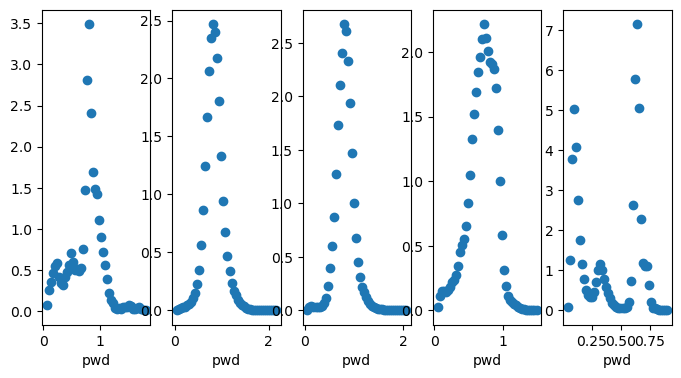

In [86]:
fig, ax = plt.subplots(1, FIs.Nintervals, figsize=(16*in2cm, 8*in2cm))  

for i in range(FIs.Nintervals):

    Xi = data.MDtraj[FIs.chi_intervals == i]
    num_conformations = Xi.n_frames
    print(num_conformations)

    distance_matrix = np.zeros((num_conformations, num_conformations))
    
    for j in range(num_conformations):
        distance_matrix[j] = md.rmsd(Xi, Xi, j)

    pwd = distance_matrix.flatten()[distance_matrix.flatten()>0]
    density, bin_edges = np.histogram(pwd, bins=50, density=True)

    ax[i].plot(bin_edges[0:-1], density, 'o')
    ax[i].set_xlabel('pwd')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)


In [101]:
FNs    =  FindNodes(data, FIs, 
                                eps =    [0.9,  0.5,    0.3,    0.5,   0.5], 
                                theta  = [10,    60,     50,     150,   20],                               
                                algorithm = 'CNNC', 
                                metric = 'mdtraj_rmsd',
                                with_noise = False) 

print(np.sum(FNs.nodes==-1))
for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])


100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

3599
Node, interval, size: 0 0 256
Node, interval, size: 1 1 67
Node, interval, size: 2 1 218
Node, interval, size: 3 1 117
Node, interval, size: 4 2 82
Node, interval, size: 5 2 56
Node, interval, size: 6 3 376
Node, interval, size: 7 3 61
Node, interval, size: 8 4 674
Node, interval, size: 9 4 494


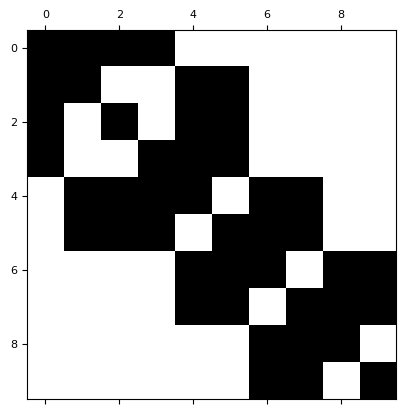

In [102]:
#BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=10, threshold =200, algorithm='mlp')
BAM    =  BuildAdjacencyMatrix(data, FNs, FIs, metric = 'mdtraj_rmsd', include_same_interval=False, r_neighbors = 0.6)


BG     =  BuildGraph(FNs, BAM)
CE     =  CalculateEnergy(FNs)

G      =  BG.G

plt.spy(BAM.A)

In [103]:
chi_nodes          = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)
gradient_chi_nodes = np.zeros((FNs.Nnodes,FNs.Nnodes))

for i in range(FNs.Nnodes):
    for j in range(FNs.Nnodes):
        gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]


/tmp/ipykernel_17337/2472132460.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]
/tmp/ipykernel_17337/2472132460.py:6: RuntimeWarning: invalid value encountered in divide
  gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]


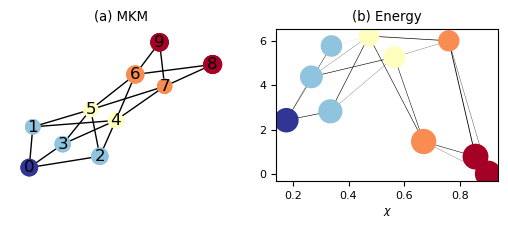

In [104]:
#posG = nx.kamada_kawai_layout(Gd)  # kamada_kawai_layout
#Make graph and nice plots
posG = nx.spring_layout(G, center=[0,0], seed = 55)  # kamada_kawai_layout

index_chi_node = FNs.index_chi_node
nodes_size     = np.log(FNs.nodes_size)*50

energy         = CE.energy
P              = BAM.P



font = {'size'   : 8}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16*in2cm, 5*in2cm), facecolor='white')

nx.draw(G, 
        posG, 
        with_labels=True, 
        node_color=index_chi_node, 
        cmap = cm.RdYlBu_r, 
        node_size= nodes_size*0.5,
        edge_color='k', 
        width=1,
        ax=ax1
       )


nx.draw_networkx_nodes(G, 
                       posG, 
                       node_size=nodes_size*0.5,
                       node_color=index_chi_node, 
                       cmap = cm.RdYlBu_r, 
                       ax=ax1)

ax1.set_title('(a) MKM')

################## PLOT ENERGY



for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if BAM.C[i,j]>0:
            ax2.plot([chi_nodes[i], chi_nodes[j]], [energy[i], energy[j]], 'k-', linewidth = np.log(1+1*BAM.C[i,j]),zorder=-1) 



ax2.scatter(chi_nodes, energy, s = nodes_size, c = index_chi_node, cmap = cm.RdYlBu_r)

ax2.set_xlabel(r'$\chi$')
ax2.set_title('(b) Energy')

#plt.subplots_adjust(left=0, bottom=0.0, right=1, top=0.99, wspace=0.0, hspace=0.0)

fig.savefig("output/figures/mokito.png", format='png', dpi=300, bbox_inches='tight')


In [105]:
nx.write_gml(G, out_mokito + "MKM.gml")

with open(out_mokito + "energy_MKM.npy", 'wb') as f:
    np.save(f, BAM.C)
    np.save(f, chi_nodes)
    np.save(f, energy)
    np.save(f, nodes_size)
    np.save(f, index_chi_node)

In [106]:
# Load relevant coordinates
Ra = np.loadtxt(out_trajectories1 + 'Ra.txt')
Rb = np.loadtxt(out_trajectories1 + 'Rb.txt')
Rc = np.loadtxt(out_trajectories1 + 'Rc.txt')

Sa = np.loadtxt(out_trajectories1 + 'Sa.txt')
Sb = np.loadtxt(out_trajectories1 + 'Sb.txt')

Ra_nodes = ProjectFunctionOntoNodes(data, Ra, FNs, periodic=False)
Rb_nodes = ProjectFunctionOntoNodes(data, Rb, FNs, periodic=False)
Rc_nodes = ProjectFunctionOntoNodes(data, Rc, FNs, periodic=False)
Sa_nodes = ProjectFunctionOntoNodes(data, Sa, FNs, periodic=False)
Sb_nodes = ProjectFunctionOntoNodes(data, Sb, FNs, periodic=False)


with open(out_mokito + "rel_coords_MKM.npy", 'wb') as f:
    np.save(f, chi_nodes)
    np.save(f, nodes_size)
    np.save(f, Ra_nodes)
    np.save(f, Rb_nodes)
    np.save(f, Rc_nodes)    
    np.save(f, Sa_nodes)    
    np.save(f, Sb_nodes)    


In [ ]:
# The following code converts the networkx graph into a mapper graph
from collections import defaultdict
import networkx as nx
import kmapper as km
from kmapper import jupyter # Creates custom CSS full-size Jupyter screen
from kmapper.plotlyviz import mpl_to_plotly



all_chi    =  chi0

mapper = km.KeplerMapper()

graph = {
    "nodes": {},
    "links": [],
    'meta_data': {'projection': 'custom',
    'n_cubes': FNs.nodes,
    'perc_overlap': 0,
    'clusterer': 'DBSCAN(min_samples=3)',
    'scaler': 'None'},
    'meta_nodes': defaultdict(list, {})
}


# States
nodes_dict = defaultdict(list)
names_nodes = {}
states_nodemembership_x0 = FNs.nodes

for i in range(FNs.Nnodes):
    key = "cube" + str(int(i)) + "_cluster0" 
    names_nodes[i] = key

for i, node in enumerate(states_nodemembership_x0):
    key = "cube" + str(int(node)) + "_cluster0" 
    nodes_dict[key].append(i)

graph["nodes"] = nodes_dict


# Edges

a = dir(FNs)    
d_links = defaultdict(list)

adjacency_matrix = BAM.Ad

np.set_printoptions(suppress=True)

for i in range(FNs.Nnodes):
    
    key_i =  "cube" + str(i) + "_cluster0" 
    
    for j in range(i + 1):
        
        key_j = "cube" + str(j) + "_cluster0" 
        
        if adjacency_matrix[i, j] > 0:
            
            d_links[key_i].append(key_j)

graph["links"] = d_links



plotly_RdYlBu = mpl_to_plotly(cm.RdYlBu_r, 20)



                

mapper.visualize(graph, 
                    path_html           = out_mokito + "MKM.html",
                    color_values        = all_chi,
                    color_function_name = "labels",
                    colorscale          = plotly_RdYlBu,
                    title               = "Molecular Kinetics Map")

#jupyter.display(path_html = out_mokito + "MKM.html")
